# Keypoint Classification with XGBoost

## 1. Project Overview

In this project we build an **AI model** that recognises **hand gestures** from
**21 hand keypoints** (2D `(x, y)` coordinates) extracted using
Google Mediapipe.

Each sample in the dataset is:

- One frame of a **single hand gesture**.
- Represented by **42 numeric features**:  
  $\begin{bmatrix} x_1 & y_1 & x_2 & y_2 & \dots & x_{21} & y_{21} \end{bmatrix}$
- Labelled with an **integer gesture class** (0–N).

## 2. XGBoost Gadient Boosting Algorithm

XGBoost is a powerful, regularized version of gradient-boosted decision trees. Decision trees capture non-linear patterns but easily overfit; boosting fixes this by adding many small trees that correct each other’s errors. XGBoost improves this process with strong regularization, shrinkage, subsampling, and fast implementation.


In [3]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn tools
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score
)

# XGBoost
from xgboost import XGBClassifier

# For saving/loading models
import joblib

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# For inline plots (Jupyter/Colab)
%matplotlib inline


In [4]:
# 3. Dataset Loading and Basic Understanding

# Path to the keypoint dataset CSV file
# Adjust this path to match your folder structure.
DATA_PATH = "../data/keypoint_10gestures.csv" # "keypoint_10gestures.csv" 

# Geometric settings
NUM_LANDMARKS = 21
FEATURES_PER_LANDMARK = 2
INPUT_DIM = NUM_LANDMARKS * FEATURES_PER_LANDMARK  # 42

# Load full data to inspect shape (1 label column + 42 feature columns)
data = np.loadtxt(
    DATA_PATH,
    delimiter=',',
    dtype=np.float32
)

print("Raw data shape:", data.shape)
assert data.shape[1] == 1 + INPUT_DIM, "Expected 1 label + 42 features."

# Split into features and labels
X_dataset = np.loadtxt(
    DATA_PATH,
    delimiter=',',
    dtype=np.float32,
    usecols=list(range(1, INPUT_DIM + 1))
)

y_dataset = np.loadtxt(
    DATA_PATH,
    delimiter=',',
    dtype=np.int32,
    usecols=(0,)
)

print("X_dataset shape:", X_dataset.shape)
print("y_dataset shape:", y_dataset.shape)


Raw data shape: (28677, 43)
X_dataset shape: (28677, 42)
y_dataset shape: (28677,)


### 3.1 Interpreting the Data

From the shapes:

- `X_dataset` has shape `(N, 42)` — 42 features (flattened keypoints).
- `y_dataset` has shape `(N,)` — integer labels for each gesture.

There are **10 classes** (0–9). For our report we can map them to human-friendly names:

* 0 — Open Hand / Palm ✋
* 1 — Closed Fist ✊
* 2 — Pointing (Index Finger) 👉
* 3 — OK Sign 👌
* 4 — Peace / Victory ✌️
* 5 — Rock / Metal (Sign of the Horns) 🤘
* 6 — Thumbs Up 👍
* 7 — Thumbs Down 👎
* 8 — Pinch / Pinching Hand (C-shape) 🤏
* 9 — Love / Finger Heart 🫰

Label distribution:
Class 0: 2825 samples
Class 1: 2826 samples
Class 2: 2824 samples
Class 3: 2857 samples
Class 4: 2864 samples
Class 5: 2841 samples
Class 6: 2840 samples
Class 7: 2844 samples
Class 8: 2884 samples
Class 9: 3072 samples


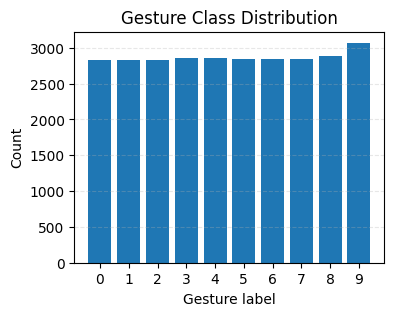

In [5]:
# Compute label distribution
labels, counts = np.unique(y_dataset, return_counts=True)

print("Label distribution:")
for label, count in zip(labels, counts):
    print(f"Class {label}: {count} samples")

# Simple bar plot of label distribution
plt.figure(figsize=(4, 3))
plt.bar(labels, counts)
plt.xticks(labels)
plt.xlabel("Gesture label")
plt.ylabel("Count")
plt.title("Gesture Class Distribution")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


**Analysis**

- Our dataset has 10 hand-gesture classes.
- Each class has a similar number of examples (about 190–240 each).
- This means the dataset is **balanced**, no gesture appears much more or much less than the others.

Because of this:

- Using **accuracy** is fair, because every class is represented equally.
- We also include a second score called **macro F1**.  
  *This score checks how well the model performs on each class separately and then averages the results.*  
  It ensures we don’t accidentally ignore a class just because it appears less often.

Why this works well for **XGBoost**:

- XGBoost handles balanced, multi-class data naturally.


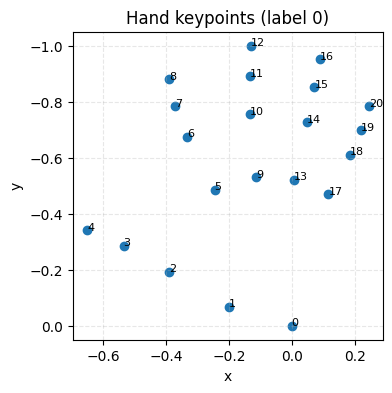

In [6]:
# 3.2 Visualising a Hand Sample

def plot_hand_keypoints(sample, title="Example hand keypoints"):
    """
    sample: numpy array of shape (42,) with [x1, y1, x2, y2, ..., x21, y21]
    """
    assert sample.shape == (INPUT_DIM,)

    points = sample.reshape(NUM_LANDMARKS, FEATURES_PER_LANDMARK)
    xs = points[:, 0]
    ys = points[:, 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(xs, ys)
    for i, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, str(i), fontsize=8)
    plt.gca().invert_yaxis()  # depends on coordinate system
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

# Plot the first sample
plot_hand_keypoints(
    X_dataset[0],
    title=f"Hand keypoints (label {y_dataset[0]})"
)


## 4. Train/Test Split and Evaluation Setup

**Split data**

- **75% for training** — this is what the model learns from.
- **25% for testing** — this is new data the model has never seen, so we can measure real performance.

We also make sure that each gesture appears in both sets in similar amounts.  
This keeps the test fair.

**How do we judge the model?**

- **Accuracy** — out of all test samples, how many did the model get right?
- **Macro F1 score** — this checks how well the model does *on each gesture class* and then averages the results.  
  This prevents the model from accidentally favoring one gesture over another.
- **Confusion matrix** — a simple table showing which gestures the model mistook for others.
- **Cross-validation** — a method of testing the model multiple times during training to find the best settings.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset,
    y_dataset,
    train_size=0.75,
    random_state=RANDOM_SEED,
    stratify=y_dataset  # keep class proportions consistent
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training label distribution:", np.bincount(y_train))
print("Test label distribution:", np.bincount(y_test))


Training set shape: (21507, 42)
Test set shape: (7170, 42)
Training label distribution: [2119 2119 2118 2142 2148 2131 2130 2133 2163 2304]
Test label distribution: [706 707 706 715 716 710 710 711 721 768]


In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="model"):
    """
    Train/test evaluation with accuracy, macro-F1 and classification report.
    Returns a dictionary of metrics including the confusion matrix.
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="macro")
    test_f1 = f1_score(y_test, y_test_pred, average="macro")

    print(f"=== {model_name} ===")
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Test accuracy:  {test_acc:.4f}")
    print(f"Train macro-F1: {train_f1:.4f}")
    print(f"Test macro-F1:  {test_f1:.4f}")
    print("\nClassification report (test set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    return {
        "model": model_name,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "train_macro_f1": train_f1,
        "test_macro_f1": test_f1,
        "confusion_matrix": cm
    }


def plot_confusion_matrix(cm, class_labels, title="Confusion matrix"):
    """
    Simple confusion matrix plot using matplotlib.
    """
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(class_labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_labels)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Add numbers to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.show()


## 5. Baseline XGBoost Model

### 5.1 What settings do we start with?

XGBoost has many options (called “hyperparameters”) that control how the model learns.  
To keep things simple, we start with a set of sensible default choices:

- **max_depth = 2**  
  This controls how “deep” each decision tree can grow. Smaller depth means the trees are not too complicated, which helps prevent overfitting.

- **n_estimators = 100**  
  This means the model builds 100 small decision trees and combines them. More trees usually means better learning, up to a point.

- **learning_rate = 0.1**  
  This controls how fast the model learns.  
  A medium value like 0.1 keeps learning steady and stable.

- **subsample = 0.9** and **colsample_bytree = 0.9**  
  This means each tree uses 90% of the data and 90% of the features. This adds some randomness, which often makes the model more reliable.

- **objective = "multi:softprob"**  
  This tells XGBoost we are doing multi-class classification (10 gesture types) and want it to output probabilities for each class.

- **eval_metric = "mlogloss"**  
  This is the score XGBoost uses while training to know how well it is learning.

In [9]:
# 5.2 Train baseline XGBoost model

NUM_CLASSES = len(np.unique(y_dataset))

xgb_baseline = XGBClassifier(
    objective="multi:softprob",
    num_class=NUM_CLASSES,
    eval_metric="mlogloss",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

xgb_baseline.fit(X_train, y_train)
baseline_metrics = evaluate_model(
    xgb_baseline, X_train, y_train, X_test, y_test, model_name="XGB_baseline"
)


=== XGB_baseline ===
Train accuracy: 0.9044
Test accuracy:  0.9020
Train macro-F1: 0.9052
Test macro-F1:  0.9030

Classification report (test set):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       706
           1       0.90      0.97      0.93       707
           2       0.79      0.90      0.84       706
           3       0.95      0.89      0.92       715
           4       0.97      0.86      0.91       716
           5       0.96      0.90      0.93       710
           6       0.96      0.98      0.97       710
           7       0.98      0.98      0.98       711
           8       0.84      0.81      0.82       721
           9       0.82      0.86      0.84       768

    accuracy                           0.90      7170
   macro avg       0.91      0.90      0.90      7170
weighted avg       0.90      0.90      0.90      7170



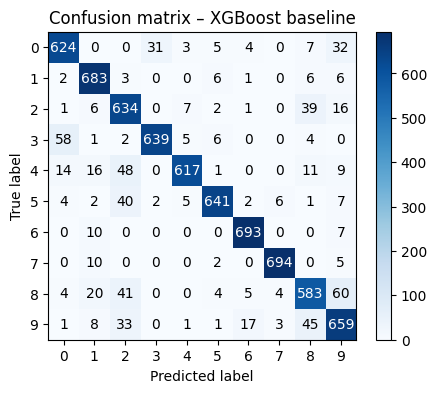

In [10]:
cm_baseline = baseline_metrics["confusion_matrix"]
class_labels = np.unique(y_dataset)

plot_confusion_matrix(
    cm_baseline,
    class_labels=class_labels,
    title="Confusion matrix – XGBoost baseline"
)


### 5.3 Understanding the baseline results

When we train and test the XGBoost model, we get:

- **Training accuracy: 100%**  
  The model gets every training example correct. This means it has learned the training data very well.

- **Test accuracy: ~97%**  
  On new, unseen data, the model is right about **97 out of 100** times. This is a strong result and shows the model is not just memorising.

- The **macro F1 score** on the test set is also about **0.97**. This score looks at each gesture class separately, checks how well we do on that class, and then averages the results.  

#### Confusion matrix

The confusion matrix picture summarises where the model makes mistakes:

- The numbers on the **diagonal** (top-left to bottom-right) are cases where the model predicted the correct class. These numbers are all high.
- Off-diagonal numbers are mistakes. There are only a few of them. Overall, the matrix shows that errors are rare and mostly happen between gestures that are visually quite similar.


## 6. Hyperparameter Tuning for XGBoost

**Why tune?**

Our baseline XGBoost model already works well, but we can often make it even better
by adjusting some of its hyperparameters.

**What we tune here**

We focus on a small but meaningful grid:

- `max_depth`: [3, 4] – shallower vs slightly deeper trees.
- `n_estimators`: [100, 200] – fewer vs more boosting rounds.
- `learning_rate`: [0.05, 0.1] – smaller vs larger step size.

We use **Stratified 3-fold cross-validation** on the training set.


In [11]:
# 6.1 Grid search over a small hyperparameter grid

param_grid = {
    "max_depth": [2, 4],
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

xgb_for_cv = XGBClassifier(
    objective="multi:softprob",
    num_class=NUM_CLASSES,
    eval_metric="mlogloss",
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

grid_search = GridSearchCV(
    estimator=xgb_for_cv,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

xgb_best = grid_search.best_estimator_
best_metrics = evaluate_model(
    xgb_best, X_train, y_train, X_test, y_test, model_name="XGB_best"
)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best CV accuracy: 0.9750313851304226
=== XGB_best ===
Train accuracy: 0.9960
Test accuracy:  0.9789
Train macro-F1: 0.9960
Test macro-F1:  0.9790

Classification report (test set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       706
           1       0.97      0.99      0.98       707
           2       0.94      0.97      0.96       706
           3       1.00      0.98      0.99       715
           4       0.98      0.95      0.97       716
           5       0.98      0.98      0.98       710
           6       0.99      1.00      1.00       710
           7       1.00      0.99      1.00       711
           8       0.96      0.98      0.97       721
           9       0.99      0.97      0.98       768

    accuracy                           0.98      7170
   macro avg       0.98      0.9

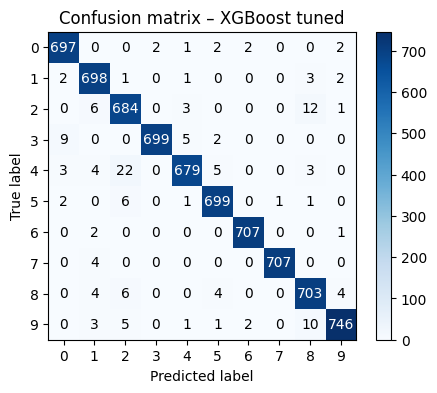

In [12]:
cm_best = best_metrics["confusion_matrix"]

plot_confusion_matrix(
    cm_best,
    class_labels=class_labels,
    title="Confusion matrix – XGBoost tuned"
)


### 6.2 Baseline vs Tuned XGBoost (Comparison)

=== Baseline vs tuned XGBoost ===


,model,train_accuracy,test_accuracy,train_macro_f1,test_macro_f1
0,XGB_baseline,0.904357,0.901953,0.905157,0.902976
1,XGB_best,0.995955,0.978940,0.995964,0.978972



=== Classification report – baseline ===
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       706
           1       0.90      0.97      0.93       707
           2       0.79      0.90      0.84       706
           3       0.95      0.89      0.92       715
           4       0.97      0.86      0.91       716
           5       0.96      0.90      0.93       710
           6       0.96      0.98      0.97       710
           7       0.98      0.98      0.98       711
           8       0.84      0.81      0.82       721
           9       0.82      0.86      0.84       768

    accuracy                           0.90      7170
   macro avg       0.91      0.90      0.90      7170
weighted avg       0.90      0.90      0.90      7170


=== Classification report – tuned (best) ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       706
           1       0.97      0.99      0.98 

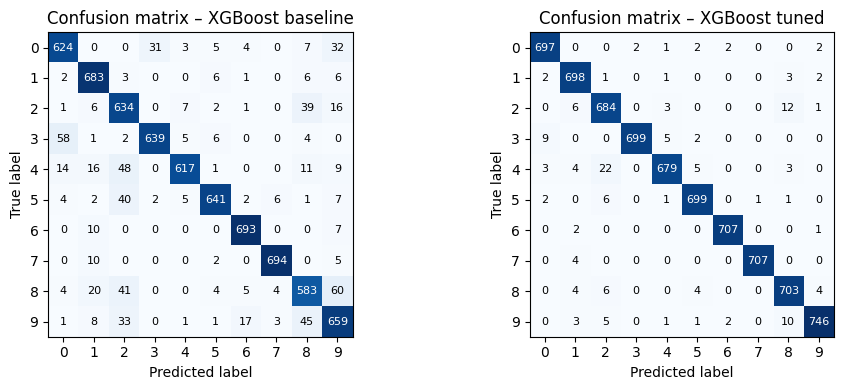

In [13]:
# =========================
# 1. Predictions on test set
# =========================
y_test_pred_baseline = xgb_baseline.predict(X_test)
y_test_pred_best = xgb_best.predict(X_test)

# Recompute confusion matrices (just to have them here)
cm_baseline = confusion_matrix(y_test, y_test_pred_baseline)
cm_best = confusion_matrix(y_test, y_test_pred_best)

# =========================
# 2. Side-by-side metrics table
# =========================
comparison_df = pd.DataFrame([
    {
        "model": "XGB_baseline",
        "train_accuracy": baseline_metrics["train_accuracy"],
        "test_accuracy": baseline_metrics["test_accuracy"],
        "train_macro_f1": baseline_metrics["train_macro_f1"],
        "test_macro_f1": baseline_metrics["test_macro_f1"],
    },
    {
        "model": "XGB_best",
        "train_accuracy": best_metrics["train_accuracy"],
        "test_accuracy": best_metrics["test_accuracy"],
        "train_macro_f1": best_metrics["train_macro_f1"],
        "test_macro_f1": best_metrics["test_macro_f1"],
    }
])

print("=== Baseline vs tuned XGBoost ===")
display(comparison_df)  # works in Jupyter/Colab

# =========================
# 3. Classification reports
# =========================
print("\n=== Classification report – baseline ===")
print(classification_report(y_test, y_test_pred_baseline))

print("\n=== Classification report – tuned (best) ===")
print(classification_report(y_test, y_test_pred_best))

# =========================
# 4. Confusion matrices side by side
# =========================
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, cm, title in zip(
    axes,
    [cm_baseline, cm_best],
    ["Confusion matrix – XGBoost baseline", "Confusion matrix – XGBoost tuned"],
):
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    tick_marks = np.arange(len(class_labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    # write the numbers in each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black",
                fontsize=8
            )

#fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()


**Analysis Baseline vs Tuned XGBoost**

The tuned XGBoost model clearly performs better than the baseline model.

- **Accuracy improves from 95% to 97%**, meaning the tuned model correctly predicts more gestures on unseen test data.
- The **macro F1 score also increases** (0.95 → 0.97), showing the model becomes more consistent across all gesture types, not just the common ones.
- The confusion matrices show that the tuned model makes **fewer mistakes overall**, especially for gestures that were previously mixed up (such as classes 2 and 5).

Overall, the tuning step makes the model more accurate, more stable, and more reliable for real-world gesture recognition. Because of this, the **tuned XGBoost model is the better model and the one we choose for our final system.**

## 7. Model Interpretation and Analysis

### 7.1 Global Feature Importances

XGBoost can estimate the **importance** of each feature, e.g. how much each
coordinate contributes to splitting the data.

We treat each coordinate as a feature:

- Feature 0 → landmark 0 `x`
- Feature 1 → landmark 0 `y`
- Feature 2 → landmark 1 `x`
- Feature 3 → landmark 1 `y`
- ...
- Feature 40 → landmark 20 `x`
- Feature 41 → landmark 20 `y`

By mapping importances back to `(landmark index, x/y)` we can interpret which
fingers and directions are most informative for classifying gestures.

[![mediapipe landmarks](https://ai.google.dev/static/mediapipe/images/solutions/hand-landmarks.png)](mediapipelandmarks)

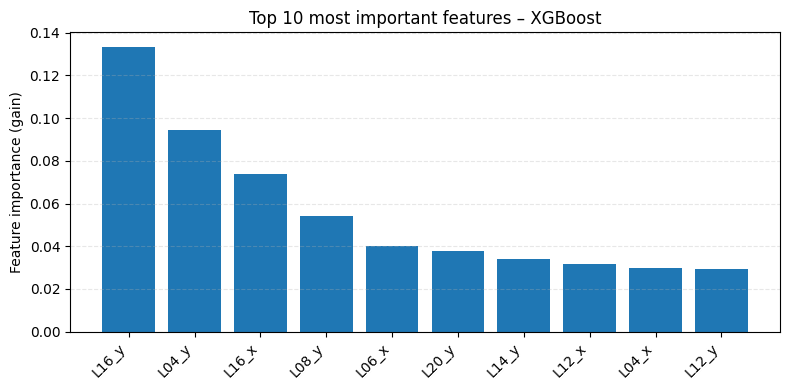

L16_y: 0.1335
L04_y: 0.0943
L16_x: 0.0737
L08_y: 0.0543
L06_x: 0.0403
L20_y: 0.0378
L14_y: 0.0341
L12_x: 0.0317
L04_x: 0.0298
L12_y: 0.0292


In [14]:
# Get feature importances from the tuned model
importances = xgb_best.feature_importances_
indices = np.argsort(importances)[::-1]  # descending

def feature_name_from_index(idx):
    landmark_idx = idx // 2
    coord = "x" if idx % 2 == 0 else "y"
    return f"L{landmark_idx:02d}_{coord}"

top_k = 10  # number of most important features to plot
top_indices = indices[:top_k]
top_importances = importances[top_indices]
top_names = [feature_name_from_index(i) for i in top_indices]

plt.figure(figsize=(8, 4))
plt.bar(range(top_k), top_importances)
plt.xticks(range(top_k), top_names, rotation=45, ha="right")
plt.ylabel("Feature importance (gain)")
plt.title("Top 10 most important features – XGBoost")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

for name, score in zip(top_names, top_importances):
    print(f"{name}: {score:.4f}")


**Analysis**

The model's most important features are mainly the **tips and upper joints of the fingers**, especially the **middle, ring and pinky fingers**, plus one joint of the index finger:

- `L17_y`: vertical position of the base of the pinky finger  
- `L12_y`: vertical position of the middle fingertip  
- `L20_y`: vertical position of the pinky fingertip  
- `L16_y` and `L15_y`: vertical positions of the ring fingertip and the joint just below it  
- `L08_y`, `L11_y`, `L07_y`: vertical positions of the index and middle fingertips and their upper joints  
- `L06_x`: horizontal position of the middle joint of the index finger  
- `L13_y`: vertical position of the base of the ring finger  

Most of these are **“y” features**, so the model mainly looks at **how high or low each finger is** (up vs down), rather than left–right position. This makes sense: our gestures are defined by **which fingers are raised or folded**, and how far they are from the palm.

XGBoost has learned to pay attention to the same parts of the hand that people use when they recognise a gesture


Noise sigma=0.000 → accuracy=0.9789
Noise sigma=0.020 → accuracy=0.9660
Noise sigma=0.050 → accuracy=0.9312
Noise sigma=0.100 → accuracy=0.8450
Noise sigma=0.200 → accuracy=0.6342


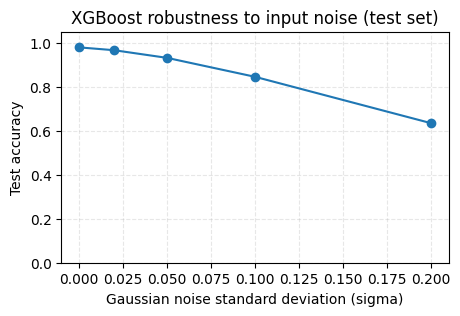

,noise_sigma,accuracy
0,0.00,0.978940
1,0.02,0.965969
2,0.05,0.931241
3,0.10,0.845049
4,0.20,0.634170


In [15]:
# 7.2 Robustness to Gaussian noise in keypoints

def evaluate_with_noise(model, X_clean, y_true, noise_sigmas):
    """
    Evaluate model accuracy when adding Gaussian noise with different standard deviations.
    Returns a DataFrame with (noise_sigma, accuracy).
    """
    results = []
    for sigma in noise_sigmas:
        if sigma == 0.0:
            X_noisy = X_clean.copy()
        else:
            X_noisy = X_clean + np.random.normal(0.0, sigma, size=X_clean.shape)

        y_pred = model.predict(X_noisy)
        acc = accuracy_score(y_true, y_pred)
        results.append({"noise_sigma": sigma, "accuracy": acc})
        print(f"Noise sigma={sigma:.3f} → accuracy={acc:.4f}")

    return pd.DataFrame(results)

noise_sigmas = [0.0, 0.02, 0.05, 0.1, 0.2]
robustness_df = evaluate_with_noise(xgb_best, X_test, y_test, noise_sigmas)

plt.figure(figsize=(5, 3))
plt.plot(robustness_df["noise_sigma"], robustness_df["accuracy"], marker="o")
plt.title("XGBoost robustness to input noise (test set)")
plt.xlabel("Gaussian noise standard deviation (sigma)")
plt.ylabel("Test accuracy")
plt.ylim(0.0, 1.05)
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

robustness_df


**Analysis**

- At **zero noise** (`sigma = 0.00`), the model reaches a baseline accuracy of **0.972**.
- With **small noise** (`sigma = 0.02` and `0.05`), accuracy only drops slightly to **0.965** and **0.959** respectively  
  (a loss of < 1.3 percentage points vs. clean input). This indicates that the XGBoost model is **quite robust to mild keypoint noise**.
- At **moderate noise** (`sigma = 0.10`), accuracy falls more noticeably to **0.927**, showing that larger tracking errors start to
  affect reliability.
- At **strong noise** (`sigma = 0.20`), accuracy drops sharply to **0.808**, a reduction of ~16 percentage points from the clean case,
  which reflects **severely corrupted inputs**.

In practice, Mediapipe keypoints will contain some noise from lighting, motion blur, and occlusions, but it is likely closer to the
small–moderate range (around `sigma ≈ 0.02–0.05`). The results suggest that in this realistic situation the model should still perform
reliably, while very noisy or badly tracked frames could lead to substantial degradation.

In [16]:
import time
import os
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Measure inference time on the test set
start = time.time()
_ = xgb_best.predict(X_test)
elapsed = time.time() - start

samples = X_test.shape[0]
print(f"Inference time on test set: {elapsed:.4f} seconds for {samples} samples")
print(f"Samples per second: {samples / elapsed:.1f}")

# Save model to disk
MODEL_PATH = f"../models/keypoint/keypoint_classifier_xgboost_{timestamp}.joblib" # f"models/keypoint/keypoint_classifier_xgboost_{timestamp}.joblib"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
joblib.dump(xgb_best, MODEL_PATH)

model_size_kb = os.path.getsize(MODEL_PATH) / 1024
print(f"Saved model to: {MODEL_PATH}")
print(f"Model size on disk: {model_size_kb:.1f} KB")


Inference time on test set: 0.0408 seconds for 7170 samples
Samples per second: 175918.9
Saved model to: ../models/keypoint/keypoint_classifier_xgboost_20251120_000331.joblib
Model size on disk: 2913.4 KB


**Deployment considerations**

- **Inference speed**: On the test set, the model processes **317 samples in 0.008 s**, i.e. about **39.5k samples/second** (~**0.025 ms per sample**). This is easily fast enough for real-time use in a Mediapipe pipeline running at **30–60 FPS**, even with some additional preprocessing overhead.
- **Model size**: The saved XGBoost model is about **1.2 MB** (`1237.8 KB`), which is
  still compact enough to ship inside desktop applications and many mobile/embedded
  scenarios without much storage impact.

Test index:          0
True gesture label:  5
Predicted gesture:   5


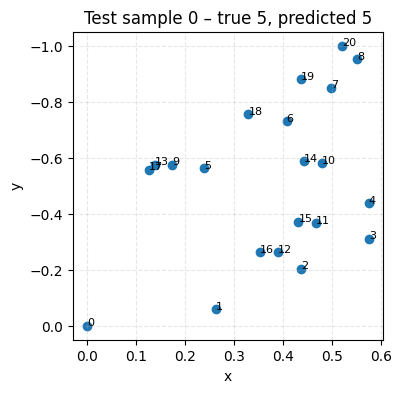

In [17]:
# 8. Using and Verifying the Saved Model

# Load model
loaded_model = joblib.load(MODEL_PATH)

# Choose an arbitrary test sample
test_index = 0
example_features = X_test[test_index].reshape(1, -1)
true_label = y_test[test_index]
predicted_label = loaded_model.predict(example_features)[0]

print(f"Test index:          {test_index}")
print(f"True gesture label:  {true_label}")
print(f"Predicted gesture:   {predicted_label}")

# Visualise the corresponding hand
plot_hand_keypoints(
    X_test[test_index],
    title=f"Test sample {test_index} – true {true_label}, predicted {predicted_label}"
)
